In [57]:
#validate GLORYS OBCs against RG ARGO gridded product for the caribbean cesm/mom6 config.
import requests, xarray, pandas, math, datetime
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
from glob import glob
import os
import matplotlib.pyplot as plt
import xesmf
from boundary import *
import pandas as pd

In [58]:
# define input data
#define a lobrary with the following inputs to standardize the datasets for comparisson
# library entries:
# 'function2standardize' -> RG_clim_standardize, OBC_standardize, MOM_Carib_out_standardize, GLORYS_standardize
# 'file_path' -> path to data
# 'file_name' -> data file name
# 'variable_name' -> variable name to evaluate
# 'Lon_name' -> longitude variable name
# 'Lat_name' -> latitude variable name
# 'Levels_name' -> vertical level variable name (i.e. 'depth', 'pressure;)
# 'vertical_convention' -> 'positive_down' or 'negative_down'
# 'save_standard_format' -> True/False
# 'time_resolution' -> monthly, daily , yearly


#RG data (downloaded using: argovis_get_RGargo.ipynb):
data_dic1 = {'function2standardize':'data_standardize',
         'file_path': '/glade/work/gseijo/obc_glorys/validation/',
         'file_name':'argo_rgTempTotal_east_boundary_carib025_2004_2014.nc',
         'variable_name':'measurement',
         'Lon_name':'longitude',
         'Lat_name':'latitude',
         'Levels_name':'pressure',
         'Time_name':'time',
         'positive_down':True,
         'save_standard_format': False,
         'time_resolution':'monthly',
          'data_tag':'RG clim'}

#OBC data:
data_dic2 = {'function2standardize':'obc_standardize',
         'file_path': '/glade/work/gseijo/obc_glorys/flooding/concat/',
         'file_name':'temp_001.nc',
         'variable_name':'temp_segment_001',
         'Lon_name':'lon_segment_001',
         'Lat_name':'lat_segment_001',
         'Levels_name':'dz_temp_segment_001',
         'Time_name':'time',
         'positive_down':True,
         'save_standard_format': False,
         'time_resolution':'daily',
         'data_tag':'OBC flooded',
         'coords_in':'/glade/work/gseijo/east_boundary_coords.nc'}

#GLORYS data:
data_dic3 = {'function2standardize':'data_standardize',
         'file_path': '/glade/work/gseijo/',
         'file_name':'global-reanalysis-phy-001-031-grepv2-monthly_OBC_EAST_data.nc',
         'variable_name':'thetao_glor',
         'Lon_name':'longitude',
         'Lat_name':'latitude',
         'Levels_name':'depth',
         'Time_name':'time',
         'positive_down':True,
         'save_standard_format': False,
         'time_resolution':'monthly',
         'data_tag':'GLORYS'}


In [59]:
ds3 = data_standardize(data_dic1['file_path'],
                      data_dic1['file_name'],
                      data_dic1['variable_name'],
                      data_dic1['Lon_name'],
                      data_dic1['Lat_name'],
                      data_dic1['Levels_name'],
                      data_dic1['Time_name'],
                      data_dic1['positive_down'],
                      data_dic1['save_standard_format'],
                      data_dic1['time_resolution'],
                      data_dic1['data_tag'])
#obc standardize is special because of the structure of the obc files as needed for mom6, we take the data from the obcs and create a new dataset
# that matches the format generated with data_standardize
ds2 = obc_standardize(data_dic2['file_path'],
                      data_dic2['file_name'],
                      data_dic2['coords_in'],
                      data_dic2['variable_name'],
                      data_dic2['Lon_name'],
                      data_dic2['Lat_name'],
                      data_dic2['Levels_name'],
                      data_dic2['Time_name'],
                      data_dic2['positive_down'],
                      data_dic2['save_standard_format'],
                      data_dic2['time_resolution'],
                      data_dic2['data_tag'])

ds1 = data_standardize(data_dic3['file_path'],
                      data_dic3['file_name'],
                      data_dic3['variable_name'],
                      data_dic3['Lon_name'],
                      data_dic3['Lat_name'],
                      data_dic3['Levels_name'],
                      data_dic3['Time_name'],
                      data_dic3['positive_down'],
                      data_dic3['save_standard_format'],
                      data_dic3['time_resolution'],
                      data_dic3['data_tag'])

(366, 75, 305, 1)


In [60]:
print(ds1)
print('--------------------------')
print(ds2)
print('--------------------------')
print(ds3)

<xarray.Dataset>
Dimensions:          (lat: 157, lon: 1, time: 180, z: 75)
Coordinates:
  * z                (z) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * lat              (lat) float32 -6.0 -5.75 -5.5 -5.25 ... 32.5 32.75 33.0
  * time             (time) datetime64[ns] 2000-01-16 2000-02-15 ... 2014-12-16
  * lon              (lon) float32 -35.5
Data variables:
    zos_glor         (time, lat, lon) float32 ...
    uo_glor          (time, z, lat, lon) float32 ...
    data             (time, z, lat, lon) float32 ...
    mlotst_glor      (time, lat, lon) float32 ...
    so_glor          (time, z, lat, lon) float32 ...
    vo_glor          (time, z, lat, lon) float32 ...
    data_tag         <U6 'GLORYS'
    time_resolution  <U7 'monthly'
Attributes: (12/17)
    product:                       GLOBAL_REANALYSIS_PHY_001_031
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    area:                          Global
    quality_information_document:

In [61]:
freq2sample = 'M'
def resample_time(ds_in): 
    ds_resampled = ds_in.resample(time=freq2sample).mean()
    ds_resampled['data_tag'] = ds_in['data_tag']
    return ds_resampled



In [62]:
num_datasets = 3
for i in range (num_datasets-1):
    vars()['ds'+str(i+1)] = resample_time(vars()['ds'+str(i+1)])

In [63]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
ds3_ind=find_nearest(ds3['lon'][:],ds2['lon'][0].values)

In [64]:
ds1 = ds1.sel(z=slice(0,140))
ds2 = ds2.sel(z=slice(0,140))
ds3 = ds3.sel(z=slice(0,140))
#ds1 = ds1.sel(time=slice(0,140))
#ds2 = ds2.sel(time=slice(0,140))
#ds3 = ds3.sel(time=slice(0,140))

In [65]:
ds1=ds1.transpose('lat','lon','z','time')
ds2=ds2.transpose('lat','lon','z','time')
ds3=ds3.transpose('lat','lon','z','time')

In [55]:
ds3['data']

<xarray.DataArray 'data' (lat: 40, z: 15, time: 132)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[27.758999, 28.063   , ..., 26.844999, 27.167999],
        [27.74    , 28.062   , ..., 26.833   , 27.151999],
        ...,
        [20.411999, 19.837999, ..., 19.962999, 20.785   ],
        [19.027   , 18.501001, ..., 18.907001, 19.043001]],

       ...,

       [[20.651001, 19.806   , ..., 22.997   , 21.453001],
        [20.650999, 19.803999, ..., 22.997   , 21.459999],
        ...,
        [19.014   , 19.391001, ..., 18.441   , 19.301001],
        [18.759001, 19.098001, ..., 18.27    , 18.776001]],

       [[20.064001, 19.234001, ..., 22.281   , 20.698002],
        [20.063999, 19.233   , ..., 22.281   , 20.703999],
        ...,
        [18.525002, 18.638   , ..., 16.93    , 17.996   ],
        [18.266001, 18.415001, ..., 16.77    , 17.635   ]]])
Coordinates:
  * lat      (lat) float64 -5.5 -4.5 -3.5 -2.5 -1.5 ... 29.5 30.5 31.5 32.5 33.5
    lon      float64 -35.5
  * time     (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2014-12-15
  * z        (z) float64 2.5 10.0 20.0 30.0 40.0 ... 110.0 120.0 130.0 140.0

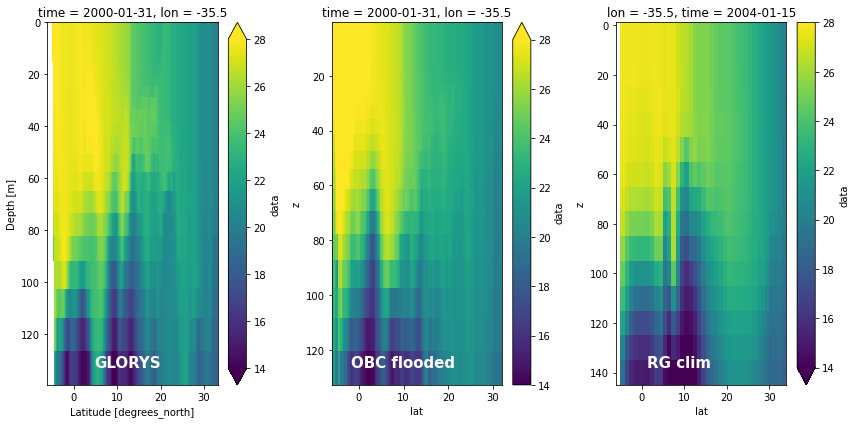

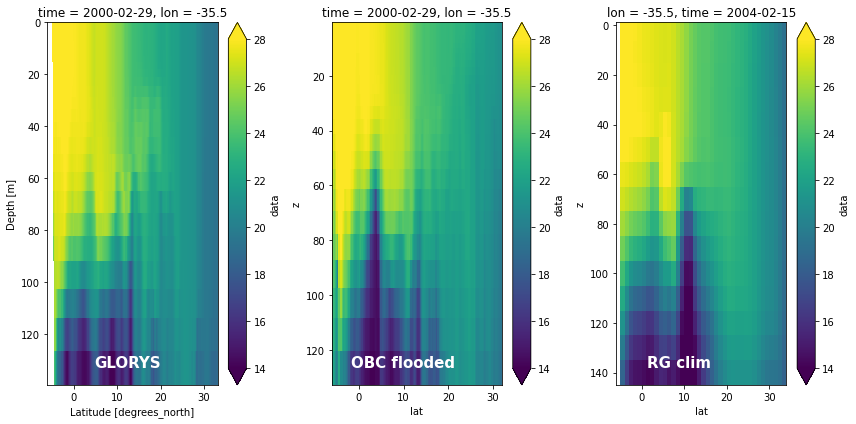

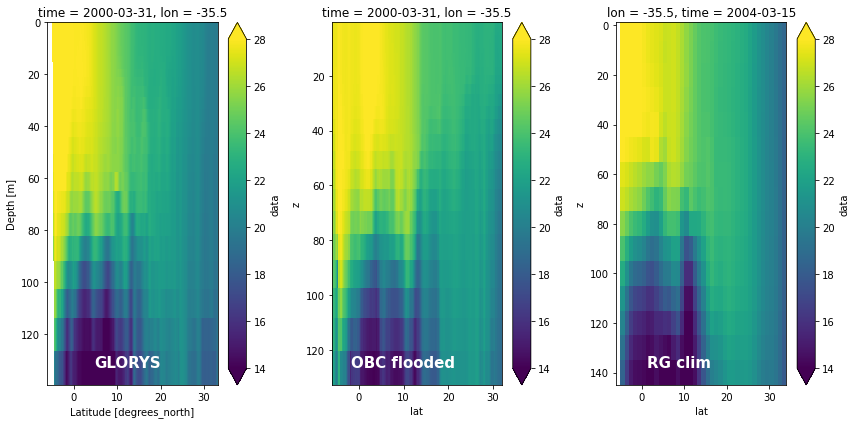

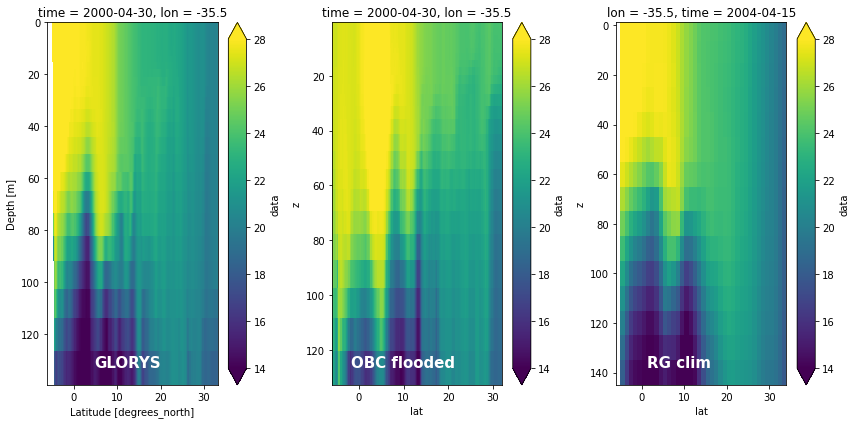

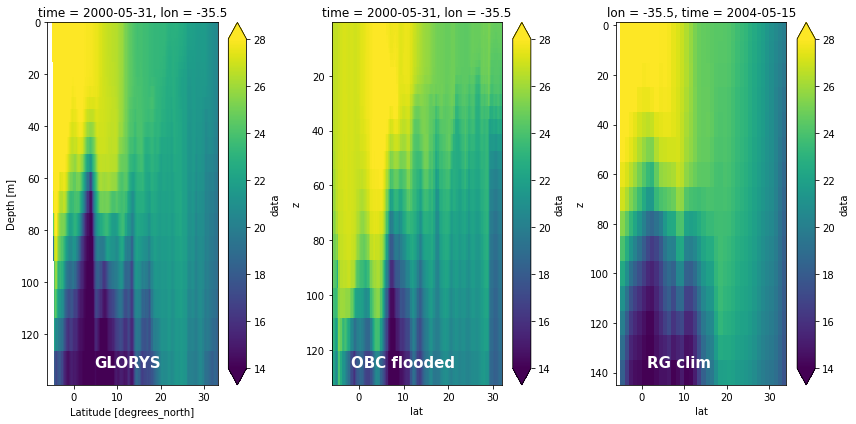

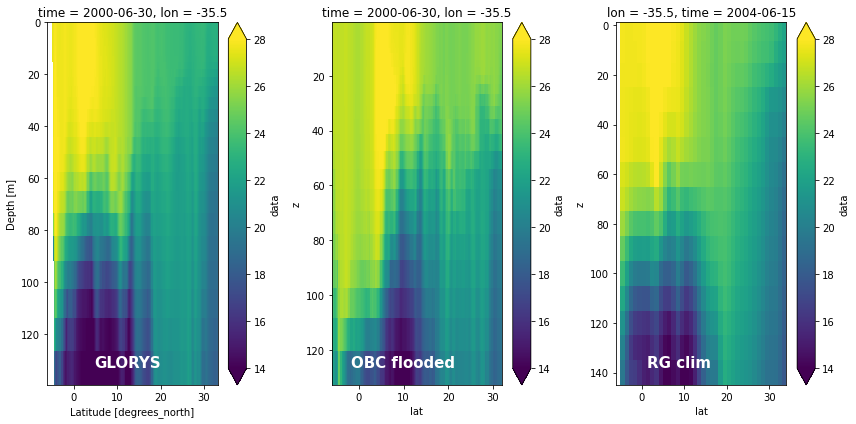

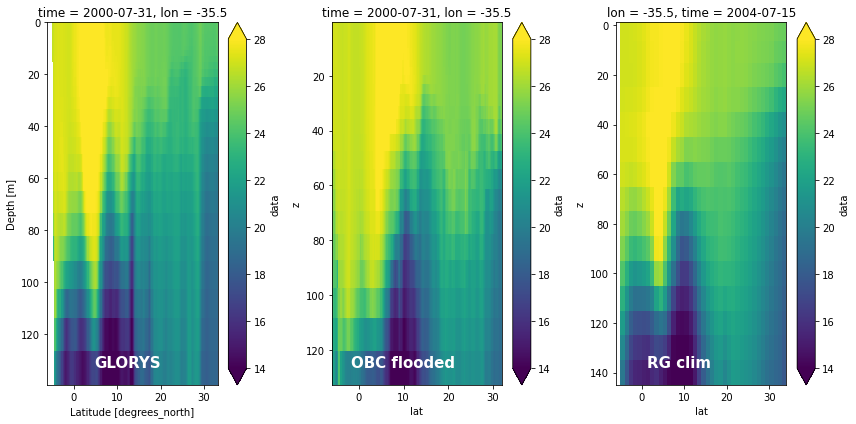

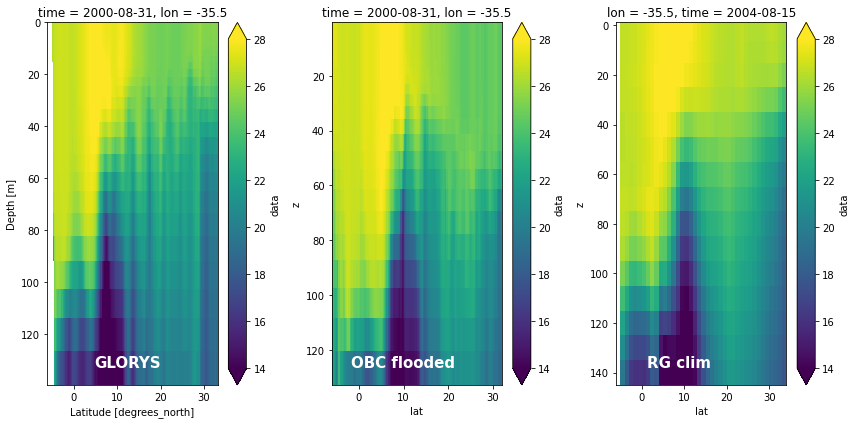

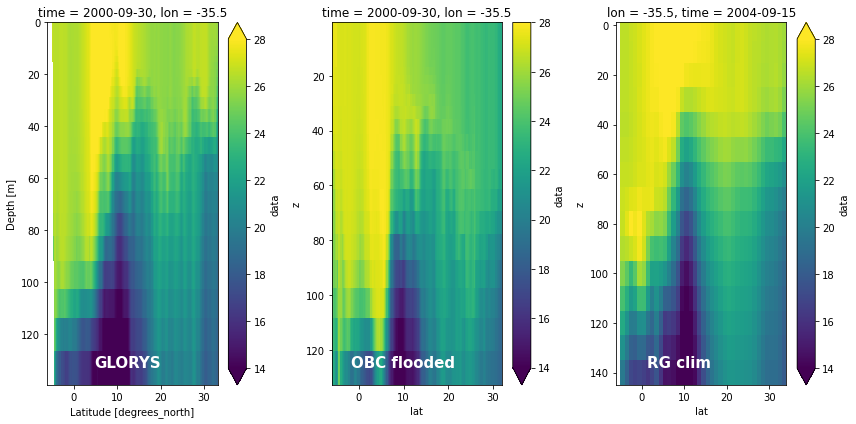

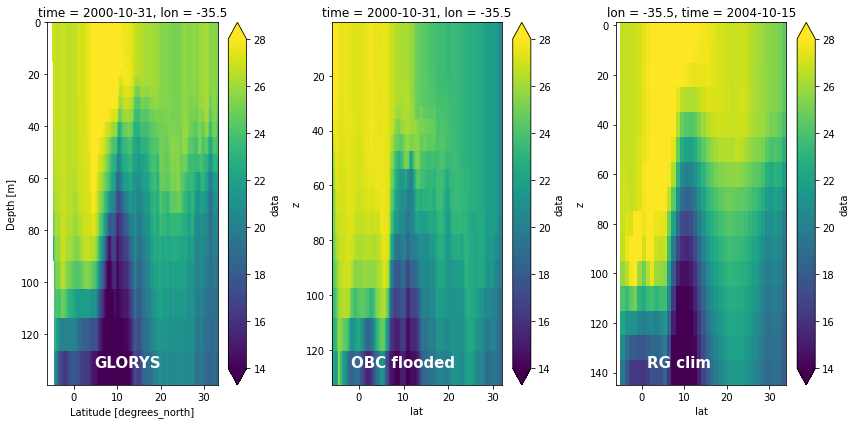

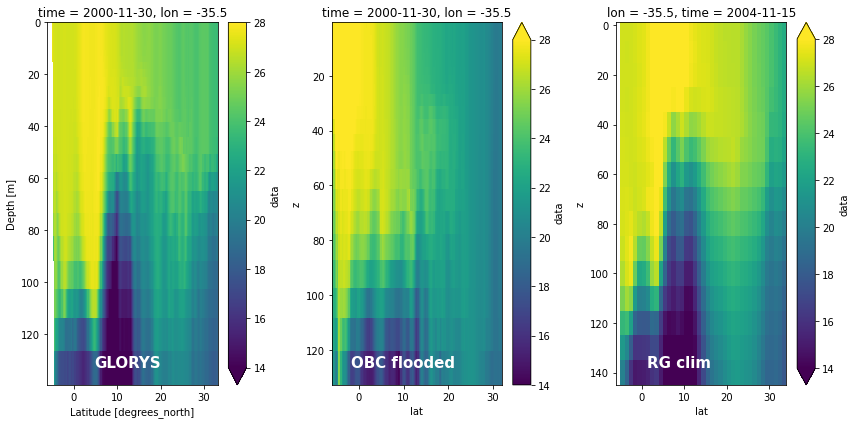

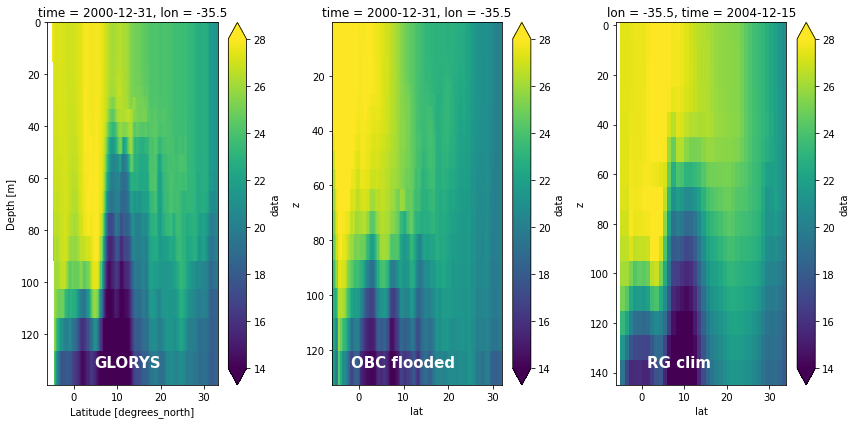

IndexError: index 12 is out of bounds for axis 3 with size 12

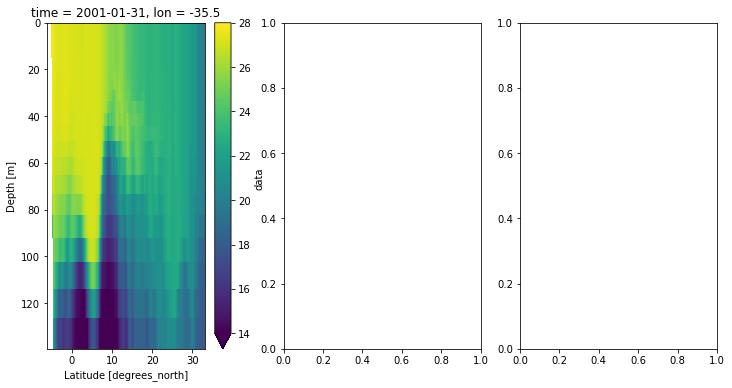

In [66]:
numdatasets=3
mini=14
maxi=28
boundary='east'
obc_validation_plot_out = '/glade/work/gseijo/obc_glorys/flooding/concat/validation/east/'
for tstep in range(len(ds1.time)):
    fig, axes = plt.subplots(ncols=num_datasets,figsize=(12, 6))

    vars()['bfr'+str(1)] = vars()['ds'+str(1)]
    vars()['bfr'+str(2)] = vars()['ds'+str(2)]
    vars()['bfr'+str(3)] = vars()['ds'+str(3)]
    if boundary=='east':
            bfr1['data'][:,0,:,tstep].transpose('z','lat').plot(ax=axes[0],yincrease=False,vmin=mini,vmax=maxi)
            bfr2['data'][:,0,:,tstep].transpose('z','lat').plot(ax=axes[1],yincrease=False,vmin=mini,vmax=maxi)
            bfr3['data'][:,ds3_ind,:,tstep].transpose('z','lat').plot(ax=axes[2],yincrease=False,vmin=mini,vmax=maxi)
            #vars()['ax'+str(nds)].pcolormesh(bfr['lat'],bfr['z'],bfr['data'][:,0,:,tstep].transpose('z','lat'),vmin=mini,vmax=maxi)
            #vars()['ax'+str(nds)].invert_yaxis()
            plt.tight_layout()
    else: 
        vars()['ax'+str(nds)].pcolormesh(bfr['lon'],bfr['z'],bfr['data'][0,:,:,tstep].transpose('z','lon'),vmin=mini,vmax=maxi)
        vars()['ax'+str(nds)].invert_yaxis()
        plt.tight_layout()
    plt.text(0.1, 0, str(bfr1['data_tag'].values),color='white',fontsize=15,weight='bold', horizontalalignment='center',verticalalignment='bottom', transform=vars()['ax'+str(0)].transAxes)
    plt.text(0.3, 0, str(bfr2['data_tag'].values),color='white',fontsize=15,weight='bold', horizontalalignment='center',verticalalignment='bottom', transform=vars()['ax'+str(1)].transAxes)
    plt.text(0.5, 0, str(bfr3['data_tag'].values),color='white',fontsize=15,weight='bold', horizontalalignment='center',verticalalignment='bottom', transform=vars()['ax'+str(2)].transAxes)

    
    plt.show()
    #plt.savefig(obc_validadtion_plot_out + bfr['time'][tstep].values + '.png')
    del bfr1, bfr2, bfr3


In [ ]:
fig_width = 12
fig_height = 12

for ii in range(1,132):       
        #rgplt = rg['psal'][:,1,it,:]
        fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(12, 6))
        ax0.pcolormesh(glorys['longitude'],glorys['depth'][0:glor_depth],glorys['so_glor'][47+ii,0:glor_depth,0,:],vmin=34,vmax=38)
        ax0.invert_yaxis()
        ax0.set_title('GLORYS: ' + str(glorys['time'][47+ii].values))
        ax1.pcolormesh(obc_mm['psal'][47+ii,0:27,0,:],vmin=34,vmax=38)
        ax1.invert_yaxis()
        ax1.set_title('OBC: '+ str(obc_mm['time'][47+ii].values))
        clb=ax2.pcolormesh(rg['longitude'],rg['pressure'],rg['psal'][0,:,ii,:].transpose('pressure','longitude'),vmin=34,vmax=38)
        ax2.invert_yaxis()
        plt.colorbar(clb)
        ax2.set_title('RG ARGO: '+ str(rg['time'][ii].values))
        plt.tight_layout()
        #plt.savefig('/glade/work/gseijo/obc_glorys/validation/' + 'eastern_salinity_' + it + '.png')